In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix,
roc_curve, roc_auc_score, classification_report, precision_recall_curve, average_precision_score)

%matplotlib inline

In [79]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [80]:
# Quick summary statistics and zero-counts (columns where 0 indicates missing)
cols_possible_zero_missing = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']


In [81]:

print('Data types:')
print(df.dtypes)


Data types:
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object


In [82]:

zero_counts = {c: int((df[c] == 0).sum()) for c in cols_possible_zero_missing}
print('\nZero counts (likely missing):', zero_counts)



Zero counts (likely missing): {'Glucose': 5, 'BloodPressure': 35, 'SkinThickness': 227, 'Insulin': 374, 'BMI': 11}


In [83]:

print('\nNull counts:')
print(df.isnull().sum())

print('\nDescriptive statistics:')
display(df.describe().transpose())



Null counts:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Descriptive statistics:


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


In [84]:

print('\nOutcome class counts:')
print(df['Outcome'].value_counts())
print('\nOutcome proportions:')
print(df['Outcome'].value_counts(normalize=True).round(3))

print('\nShape:', df.shape)
print('Columns:', list(df.columns))




Outcome class counts:
Outcome
0    500
1    268
Name: count, dtype: int64

Outcome proportions:
Outcome
0   0.651
1   0.349
Name: proportion, dtype: float64

Shape: (768, 9)
Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


In [85]:
# Convert known-zero placeholders to NaN and show missingness + correlation
cols_missing_zero = cols_possible_zero_missing

df_clean = df.copy()
df_clean[cols_missing_zero] = df_clean[cols_missing_zero].replace(0, np.nan)

print('Missing after replacing zeros:')
print(df_clean[cols_missing_zero].isnull().sum())

print('\nDescribe (with NaNs unchanged):')
display(df_clean.describe().transpose())


Missing after replacing zeros:
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

Describe (with NaNs unchanged):


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,763.000,121.687,30.536,44.000,99.000,117.000,141.000,199.000
BloodPressure,733.000,72.405,12.382,24.000,64.000,72.000,80.000,122.000
SkinThickness,541.000,29.153,10.477,7.000,22.000,29.000,36.000,99.000
Insulin,394.000,155.548,118.776,14.000,76.250,125.000,190.000,846.000
BMI,757.000,32.457,6.925,18.200,27.500,32.300,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


In [86]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class BiologicallySaneImputer(BaseEstimator, TransformerMixin):
    def __init__(self, target_col, seed=42):
        self.target_col = target_col
        self.seed = seed
        # Biologically grounded distribution plan
        self.distribution_plan = [
            (0, 25, 0.156), (25, 50, 0.247), (50, 100, 0.273),
            (100, 150, 0.143), (150, 200, 0.078), (200, 300, 0.059),
            (300, 400, 0.026), (400, 600, 0.013), (600, 850, 0.005)
        ]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        np.random.seed(self.seed)  # Reproducibility
        
        # 0. Treat extreme hyperinsulinemia as unreliable
        extreme_mask = X[self.target_col] > 400
        X.loc[extreme_mask, self.target_col] = np.nan
        
        # 1. Identify NaNs (original zeros + extreme outliers)
        mask = X[self.target_col].isnull()
        num_missing = mask.sum()

        if num_missing > 0:
            simulated_values = []

            # 2. Log-uniform biological simulation
            for low, high, prob in self.distribution_plan:
                count = int(prob * num_missing)
                low_adj = max(low, 1)  # avoid log(0)
                chunk = np.exp(
                    np.random.uniform(np.log(low_adj), np.log(high), size=count)
                )
                simulated_values.extend(chunk)

            # 3. Fix rounding drift
            diff = num_missing - len(simulated_values)
            if diff > 0:
                simulated_values.extend(
                    np.exp(np.random.uniform(np.log(25), np.log(75), size=diff))
                )
            elif diff < 0:
                simulated_values = simulated_values[:num_missing]

            # 4. Inject ONLY into missing/extreme rows
            np.random.shuffle(simulated_values)
            X.loc[mask, self.target_col] = simulated_values

        return X


# Apply the biologically sane imputation
insulin_sim = BiologicallySaneImputer(target_col='Insulin')
df_clean = insulin_sim.transform(df_clean)

# Verification checks
print(f"Check: Values < 60 are still present: {len(df_clean[df_clean['Insulin'] < 60])}")
print(f"Check: Any remaining NaNs? {df_clean['Insulin'].isnull().sum()}")
print(f"Check: Extreme values > 600: {(df_clean['Insulin'] > 600).sum()}")


Check: Values < 60 are still present: 250
Check: Any remaining NaNs? 0
Check: Extreme values > 600: 1


In [87]:
#Inspect the insulin column
try:
    data = df_clean
except NameError:
    data = df
ins = pd.to_numeric(data['Insulin'], errors='coerce')

# thresholds
below_thresholds = [50, 100]
above_thresholds = list(range(300, 801, 100))  # 300,400,...,800

counts = {}
for t in below_thresholds:
    counts[f'below_{t}'] = int((ins < t).sum())

counts['ge_100'] = int((ins >= 100).sum())
counts['ge_200'] = int((ins >= 200).sum())

for t in above_thresholds:
    counts[f'ge_{t}'] = int((ins >= t).sum())

# diagnostics
total_nonnull = int(ins.notnull().sum())
print(f"Total non-null Insulin values: {total_nonnull}")
for k, v in counts.items():
    print(f"{k}: {v}")


df_clean['Insulin'].describe()



Total non-null Insulin values: 768
below_50: 197
below_100: 413
ge_100: 355
ge_200: 108
ge_300: 34
ge_400: 6
ge_500: 4
ge_600: 1
ge_700: 1
ge_800: 0


count   768.000
mean    113.166
std      90.456
min       1.069
25%      49.000
50%      92.631
75%     155.000
max     794.693
Name: Insulin, dtype: float64

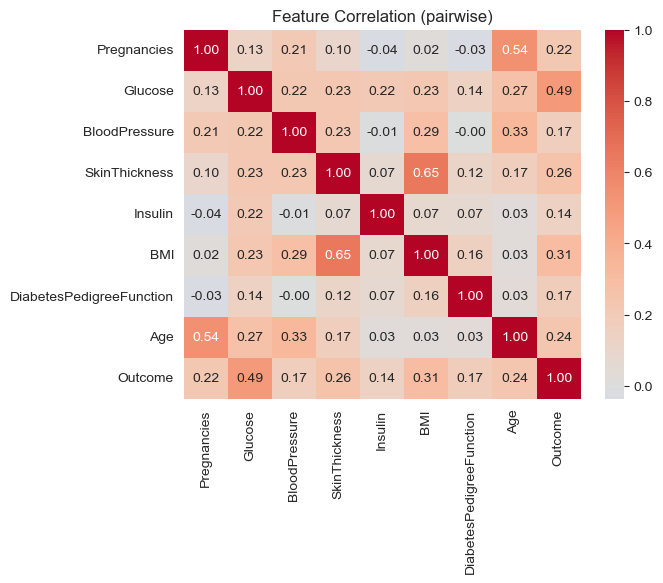

In [88]:

# Correlation heatmap (uses pairwise complete observations)
#plt.figure(figsize=(9,7))
sns.heatmap(df_clean.corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature Correlation (pairwise)')
plt.show()


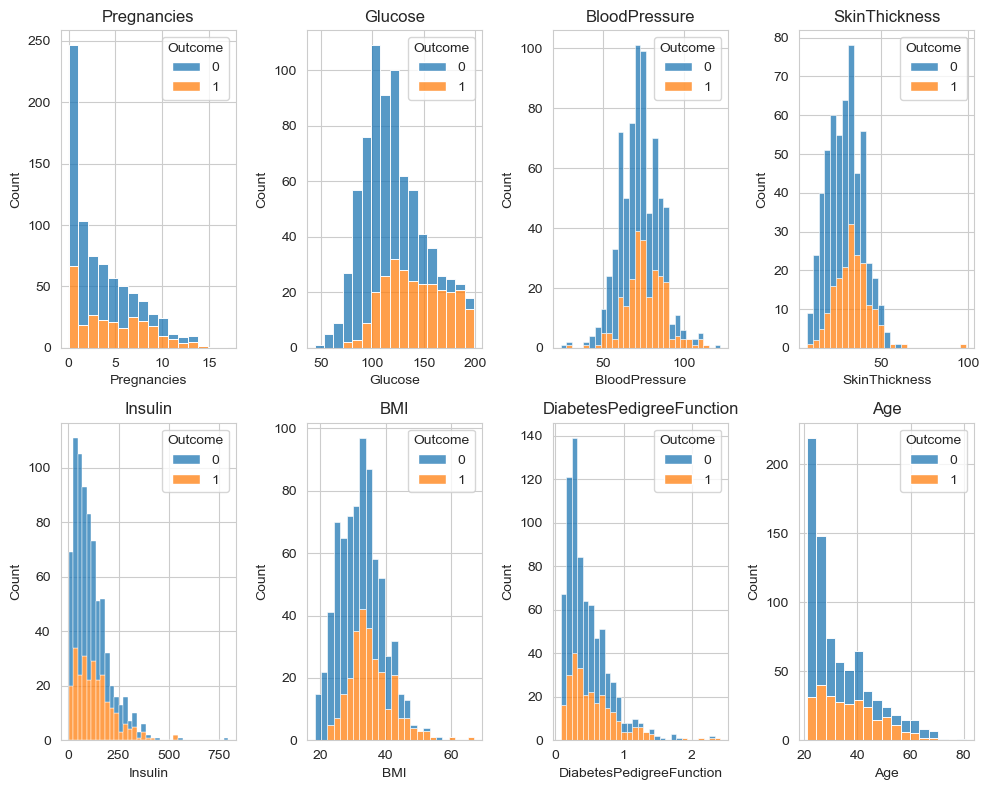

In [89]:
#distributions by Outcome
features = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']

fig, axes = plt.subplots(2,4, figsize=(10,8
))
for ax, feat in zip(axes.flatten(), features):
    sns.histplot(data=df_clean, x=feat, hue='Outcome', multiple='stack', kde=False, ax=ax)
    ax.set_title(feat)
plt.tight_layout()
plt.show()


In [90]:
df_clean.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000,763.000,733.000,541.000,768.000,757.000,768.000,768.000,768.000
mean,3.845,121.687,72.405,29.153,113.166,32.457,0.472,33.241,0.349
std,3.370,30.536,12.382,10.477,90.456,6.925,0.331,11.760,0.477
min,0.000,44.000,24.000,7.000,1.069,18.200,0.078,21.000,0.000
25%,1.000,99.000,64.000,22.000,49.000,27.500,0.244,24.000,0.000
50%,3.000,117.000,72.000,29.000,92.631,32.300,0.372,29.000,0.000
75%,6.000,141.000,80.000,36.000,155.000,36.600,0.626,41.000,1.000
max,17.000,199.000,122.000,99.000,794.693,67.100,2.420,81.000,1.000


In [91]:
# Split data
X = df_clean.drop('Outcome', axis=1)
y = df_clean['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Features shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")

Features shape: (768, 8)
Target distribution:
Outcome
0    500
1    268
Name: count, dtype: int64


In [92]:
# Scale features (mostly for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)